# Phase 2 Group 1 Project

# Import

In [1]:
#import appropriate libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
pd.set_option('display.max_columns', None)
%matplotlib inline

# Review the Data File

In [2]:
#read in the file
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
#check the first 5 entries in the data
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
#check the columns and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Cleaning the Data

In [5]:
#for year renovated, convert any houses that have been renovated to '1' to indicate true
#for any nulls, assume no renovation
df['yr_renovated'].fillna(0, inplace=True)
df['yr_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else x)

In [6]:
df.rename(columns={'yr_renovated': 'if_renovated'}, inplace=True)

In [7]:
#for any nulls, assume no waterfront
df['waterfront'].fillna(0, inplace=True)

In [8]:
#for any nulls, assume no one viewed the property
df['view'].fillna(0, inplace=True)

In [9]:
#clean up sqft_basement and convert to int
df['sqft_basement'] = df['sqft_basement'].replace({'?':np.nan}).astype(float)
df['sqft_basement'].fillna(df['sqft_living']-df['sqft_above'], inplace=True)

In [10]:
#retrieve the months and year
df['month_of_date'] = pd.DatetimeIndex(df['date']).month
df['year_of_date'] = pd.DatetimeIndex(df['date']).year

In [11]:
#convert yr_built to age of house by subtracting year the property was sold by the year it was built
#to create a more sensible column 
df['age_of_house'] = df['year_of_date'] - df['yr_built']

#drop year of date because years are only 2014 and 2015, and will not impact our predicative model
#drop yr_built b/c it is redundant with age_of_house
df.drop(columns=['year_of_date'], inplace=True)
df.drop(columns=['yr_built'], inplace=True)

In [12]:
#drop duplicates if any
df.drop_duplicates(inplace=True)

In [13]:
#drop id and date columns
df.drop(columns=['id'], inplace=True)
df.drop(columns=['date'], inplace=True)

In [14]:
#reset index
df.reset_index(inplace=True, drop=True)

In [15]:
#convert some of the categorical data from floats to ints
df['waterfront'] = df['waterfront'].astype(int)
df['view'] = df['view'].astype(int)
df['sqft_basement'] = df['sqft_basement'].astype(int)
df['if_renovated'] = df['if_renovated'].astype(int)

In [16]:
#check cleaned data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  int32  
 7   view           21597 non-null  int32  
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  int32  
 12  if_renovated   21597 non-null  int32  
 13  zipcode        21597 non-null  int64  
 14  lat            21597 non-null  float64
 15  long           21597 non-null  float64
 16  sqft_living15  21597 non-null  int64  
 17  sqft_lot15     21597 non-null  int64  
 18  month_

In [17]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,if_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_of_date,age_of_house
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,0,98178,47.5112,-122.257,1340,5650,10,59
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1,98125,47.7210,-122.319,1690,7639,12,63
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,0,98028,47.7379,-122.233,2720,8062,2,82
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,0,98136,47.5208,-122.393,1360,5000,12,49
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,0,98074,47.6168,-122.045,1800,7503,2,28


# EDA

### Target: Price

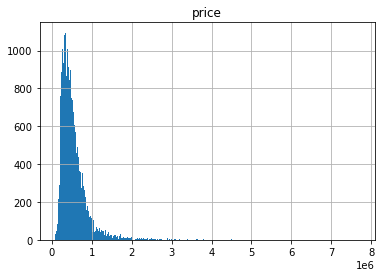

In [18]:
#Since price is our target, we will explore first
#view distribution of price using histogram
df.hist(column=['price'], bins='auto');

<AxesSubplot:>

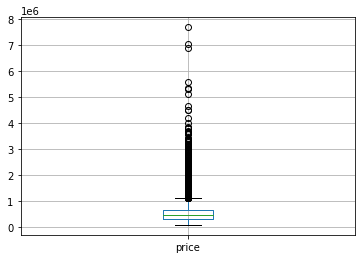

In [19]:
df.boxplot(column=['price'])

In [20]:
#Because the data is skewed to the right, transform the price data using log
df['ln_price'] = np.log(df['price'])

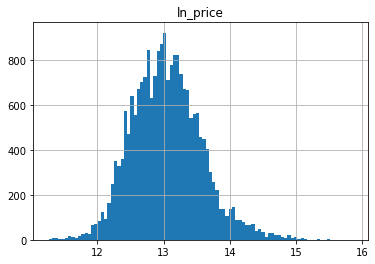

In [21]:
#view distribution of log base e for price using histogram
df.hist(column=['ln_price'], bins='auto');

<AxesSubplot:>

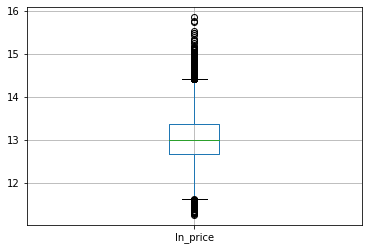

In [22]:
df.boxplot(column=['ln_price'])

### Predictors: Everything Else

In [23]:
#sns.pairplot(df)

In [24]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'if_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month_of_date', 'age_of_house',
       'ln_price'],
      dtype='object')

In [25]:
#based on the pairplot, we can see which data are categorical and which are numeric
numeric = ['bedrooms', 
           'bathrooms', 
           'sqft_living', 
           'sqft_lot', 
           'sqft_above', 
           'sqft_basement',
           'lat', 
           'long',
           'sqft_living15', 
           'sqft_lot15']

categorical = ['floors',
               'waterfront', 
               'view', 
               'condition', 
               'grade',
               'if_renovated',
               'zipcode',
               'month_of_date']

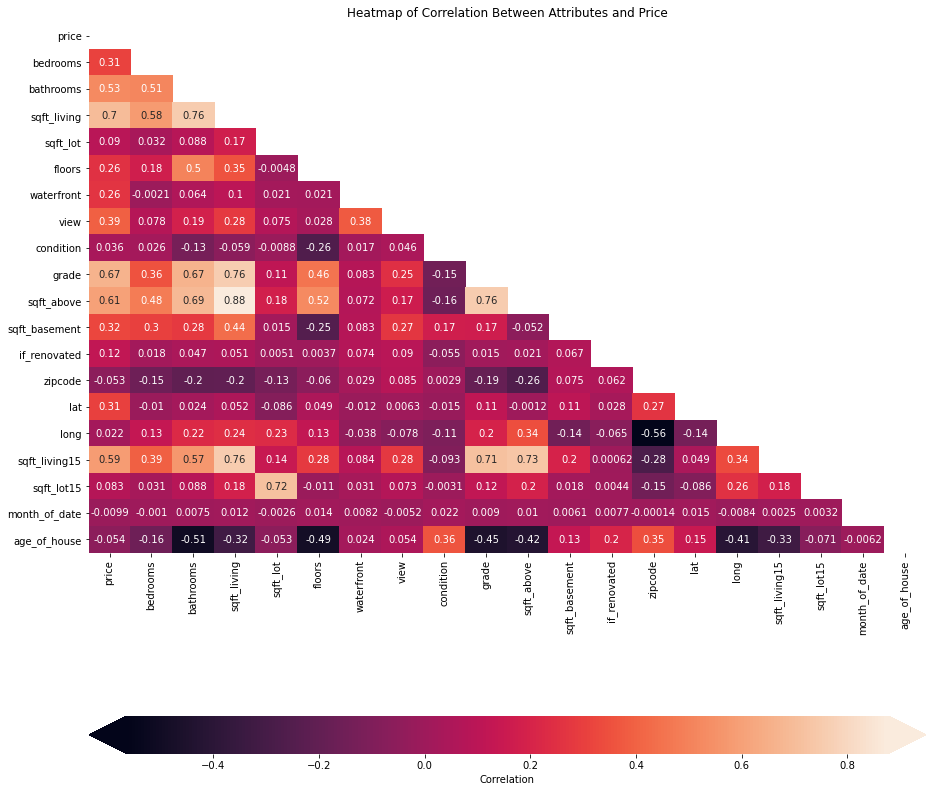

In [26]:
# Create a df with the target as the first column,
# then compute the correlation matrix
X = df.drop(['price', 'ln_price'], axis = 1)
y = df['price']
ln_y = df['price']
heatmap_data = pd.concat([y, X], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes and Price");

In [27]:
#reporting the correlation between price (target) and predictors
df.corr()['price'].drop(['ln_price']).map(abs).sort_values(ascending=False)

price            1.000000
sqft_living      0.701917
grade            0.667951
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
view             0.393497
sqft_basement    0.323799
bedrooms         0.308787
lat              0.306692
waterfront       0.264306
floors           0.256804
if_renovated     0.117543
sqft_lot         0.089876
sqft_lot15       0.082845
age_of_house     0.053890
zipcode          0.053402
condition        0.036056
long             0.022036
month_of_date    0.009928
Name: price, dtype: float64

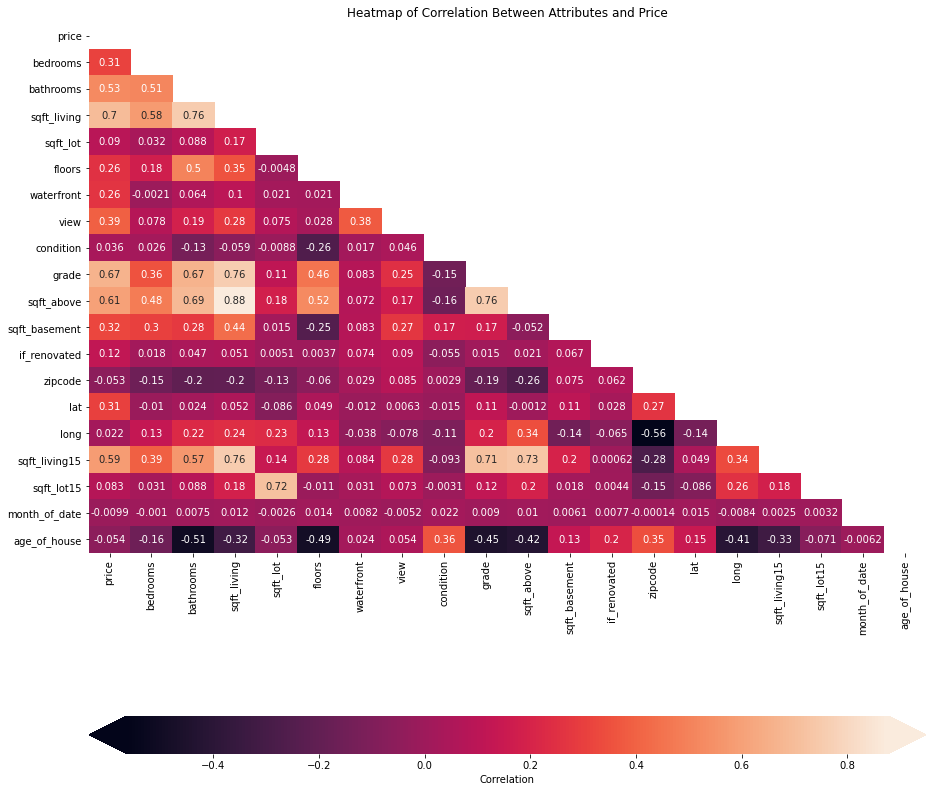

In [28]:
# Create a df with the target as the first column,
# then compute the correlation matrix
X = df.drop(['price', 'ln_price'], axis = 1)
ln_y = df['price']
heatmap_data = pd.concat([ln_y, X], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes and Price");

In [29]:
#reporting the correlation between ln price (target) and predictors
df.corr()['ln_price'].drop(['price']).map(abs).sort_values(ascending=False)

ln_price         1.000000
grade            0.703720
sqft_living      0.695185
sqft_living15    0.619326
sqft_above       0.601579
bathrooms        0.551249
lat              0.448837
view             0.344653
bedrooms         0.343360
sqft_basement    0.316920
floors           0.310630
waterfront       0.170720
if_renovated     0.106528
sqft_lot         0.100025
sqft_lot15       0.092281
age_of_house     0.080499
long             0.050862
condition        0.038918
zipcode          0.038788
month_of_date    0.013064
Name: ln_price, dtype: float64

### Declaring Funcitons:

In [30]:
def cross_val(model,X=X,y=ln_y,cv=[10]):
    return {x:(np.median(cross_val_score(model,X,y,cv=x)),np.std(cross_val_score(model,X,ln_y,cv=x))) for x in cv}

# Baseline Model

## Baseline: Data Manipulation

In [31]:
#create a new df based on the cleaned df
bdf = df

#dummying categorical 
bdf = pd.get_dummies(bdf, prefix=categorical, prefix_sep='_', columns=categorical, drop_first=True)

#remove any periods from column names after dummying the data
modified_cols = []
for column in bdf.columns:
    modified_cols.append(column.replace(".", "_"))
bdf.columns = modified_cols

## Baseline: Training and Testing

In [32]:
#create the appropriate x and y data sets
X = bdf.drop(['price','ln_price'], axis = 1)
y = bdf['price']
ln_y = bdf['ln_price']

#standardizing X values
ss = StandardScaler()
ss.fit(X)
X_scaled = pd.DataFrame(ss.transform(X))
X_scaled.columns = X.columns

#create the training and testing samples for both the price and ln_price data
X_train1, X_test1, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)
X_train2, X_test2, ln_y_train, ln_y_test = train_test_split(X_scaled, ln_y, test_size=0.20, random_state=42)

In [33]:
#instatiate a splitter with n_splits = 10
splitter = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)

In [34]:
#create a dummy regressor model based on the target as price
baseline_model = DummyRegressor(strategy='mean')
baseline_model.fit(X_train1,y_train)

#setting up cross validation for price in a different way (x3)
baseline_scores = cross_validate(
    estimator=baseline_model,
    X=X_train1,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", np.median(baseline_scores["train_score"]))
print("Validation score:", np.median(baseline_scores["test_score"]))

Train score:      0.0
Validation score: -0.00015617879540075208


In [35]:
#create a dummy regressor model based on the target as price
baseline_ln_model = DummyRegressor(strategy='mean')
baseline_ln_model.fit(X_train2,ln_y_train)

#setting up cross validation for ln price in a different way (x3)
baseline_ln_scores = cross_validate(
    estimator=baseline_ln_model,
    X=X_train2,
    y=ln_y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", np.median(baseline_ln_scores["train_score"]))
print("Validation score:", np.median(baseline_ln_scores["test_score"]))

Train score:      0.0
Validation score: -5.123718752975126e-05


In [36]:
#find the test score using the dummy regression model
baseline_train_score = baseline_model.score(X_train1, y_train)
baseline_ln_train_score = baseline_ln_model.score(X_train2, ln_y_train)
baseline_test_score = baseline_model.score(X_test1, y_test)
baseline_ln_test_score = baseline_ln_model.score(X_test2, ln_y_test)

print("Baseline model train score:", baseline_train_score)
print("Baseline model test score:", baseline_test_score)
print()
print("Baseline model train ln score:", baseline_ln_train_score)
print("Baseline model test ln score:", baseline_ln_test_score)

Baseline model train score: 0.0
Baseline model test score: -0.00028681792529150485

Baseline model train ln score: 0.0
Baseline model test ln score: -0.00021849595245027054


We find that the baseline model R-squared value is approximately 0.

In [37]:
cross_val(baseline_model,cv=[5,10,20])

{5: (-0.0009421477835616088, 0.007097926007301168),
 10: (-0.00047767087685191, 0.019009790469435767),
 20: (-0.0005236702412061423, 0.017143887472283834)}

# Model 1

Model 1 uses a multiple linear regression model of the data using all parameters, including the dummied out categorical parameters.

## Model 1: Data Manipulation

In [38]:
#create a new df based on the cleaned df
m1df = df

#dummying categorical 
m1df = pd.get_dummies(m1df, prefix=categorical, prefix_sep='_', columns=categorical, drop_first=True)

#remove any periods from column names after dummying the data
modified_cols = []
for column in m1df.columns:
    modified_cols.append(column.replace(".", "_"))
m1df.columns = modified_cols

## Model 1: Training and Testing

In [39]:
#create the appropriate x and y data sets
X = m1df.drop(['price','ln_price'], axis = 1)
y = m1df['price']
ln_y = m1df['ln_price']

#standardizing X values
ss = StandardScaler()
ss.fit(X)
X_scaled = pd.DataFrame(ss.transform(X))
X_scaled.columns = X.columns

#create the training and testing samples for both the price and ln_price data
X_train1, X_test1, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)
X_train2, X_test2, ln_y_train, ln_y_test = train_test_split(X_scaled, ln_y, test_size=0.20, random_state=42)

In [40]:
#instatiate a splitter with n_splits = 10
splitter = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)

In [41]:
#create linear regression model for price and setting up cross validation 
m1df_model = LinearRegression()
m1df_model.fit(X_train1, y_train)

#setting up cross validation for price in a different way 
m1df_scores = cross_validate(
    estimator=m1df_model,
    X=X_train1,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", np.median(m1df_scores["train_score"]))
print("Validation score:", np.median(m1df_scores["test_score"]))

Train score:      0.8439076114810683
Validation score: 0.8308942703795275


In [42]:
#create linear regression model for ln price and setting up cross validation (x3)
m1df_ln_model = LinearRegression()
m1df_ln_model.fit(X_train2, ln_y_train)

#setting up cross validation for ln price in a different way (x3)
ln_scores = cross_validate(
    estimator=m1df_ln_model,
    X=X_train2,
    y=ln_y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", np.median(ln_scores["train_score"]))
print("Validation score:", np.median(ln_scores["test_score"]))

Train score:      0.8826943413064616
Validation score: 0.8796353656029774


In [43]:
#find the test score using the linear model
m1df_train_score = m1df_model.score(X_train1, y_train)
m1df_ln_train_score = m1df_ln_model.score(X_train2, ln_y_train)
m1df_test_score = m1df_model.score(X_test1, y_test)
m1df_ln_test_score = m1df_ln_model.score(X_test2, ln_y_test)

print("m1df model train score:", m1df_train_score)
print("m1df model test score:", m1df_test_score)
print("score varied by", round(abs(m1df_test_score - m1df_train_score)/m1df_train_score*100),"%")
print()
print("m1df ln model train score:", m1df_ln_train_score)
print("m1df ln model test score:", m1df_ln_test_score)
print("score varied by", round(abs(m1df_ln_test_score - m1df_ln_train_score)/m1df_ln_train_score*100),"%")

m1df model train score: 0.8429429922259738
m1df model test score: 0.8102223927114361
score varied by 4.0 %

m1df ln model train score: 0.8824554130032448
m1df ln model test score: 0.8798250920810333
score varied by 0.0 %


We see that Model 1 outputted a higher R-squared value than the Baseline model between 0.8 and 0.9. In addition, Model 1 train and test scores varied by < 5%. The model that used the log-transformed price data had a higher R-squared value than the untransformed price data model.

In [44]:
check = [5,10,20]
m1_cross_results = {x:
           (np.median(cross_val_score(m1df_ln_model,X,ln_y,cv=x)),np.std(cross_val_score(m1df_ln_model,X,ln_y,cv=x))) 
           for x in check}
m1_cross_results

{5: (0.8774519056500676, 5.111610392130009),
 10: (0.8773037771873611, 13.55338409117993),
 20: (0.8803737963663083, 110.92348889680716)}

## Model 1: OLS

In [45]:
#set target
target = 'price'
ln_target = 'ln_price'

#concate the X and y of the train tests to apply the OLS to the full train data
train_df = pd.concat([X_train1,y_train], axis=1)
train_ln_df = pd.concat([X_train2,ln_y_train], axis=1)

#join the column names with "+"
columns = "+".join(train_df.drop(['price'], axis=1).columns)
columns_ln = "+".join(train_ln_df.drop(['ln_price'], axis=1).columns)

In [46]:
#set formulas
formula = target + '~' + columns
ln_formula = ln_target + '~' +columns

In [47]:
#create the OLS
m1df_ols = ols(formula, train_df).fit()
m1df_ln_ols = ols(ln_formula, train_ln_df).fit()

In [48]:
#report out the OLS 
m1df_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     800.9
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:13:43   Log-Likelihood:            -2.2999e+05
No. Observations:               17277   AIC:                         4.602e+05
Df Residuals:                   17161   BIC:                         4.611e+05
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         5.407e+05   1116.969    484.115      0.000    5.39e+05    5.43e+05
bedrooms         -1.221e+04   1557.682     -7.842      0.000   -1.53e+04   -9161.759
bathrooms         1.926e+04   2103.132      9.160      0.000    1.51e+04    2.34e+04
sqft_living       6.975e+04   1400.426     49.803      0.000     6.7e+04    7.25e+04
sqft_lot          1.008e+04   1659.265      6.077      0.000    6831.754    1.33e+04
sqft_above        6.891e+04   1541.213     44.714      0.000    6.59e+04    7.19e+04
sqft_basement     1.579e+04   1329.620     11.876      0.000    1.32e+04    1.84e+04
lat               3.454e+04   8977.194      3.847      0.000    1.69e+04    5.21e+04
long              -2.68e+04   6467.044     -4.143      0.000   -3.95e+04   -1.41e+04
sqft_living15     1.515e+04   2062.445      7.345      0.000    1.11e+04    1.92e+04
sqft_lot15       -4862.8288   1687.210     -2.882      0.004   -8169.933   -1555.725
age_of_house      5145.3227   2105.890      2.443      0.015    1017.563    9273.082
floors_1_5       -2152.6457   1289.724     -1.669      0.095   -4680.636     375.344
floors_2_0       -1.427e+04   1869.735     -7.632      0.000   -1.79e+04   -1.06e+04
floors_2_5        3920.5053   1188.401      3.299      0.001    1591.119    6249.892
floors_3_0       -1.237e+04   1400.768     -8.832      0.000   -1.51e+04   -9625.826
floors_3_5         -18.1732   1005.949     -0.018      0.986   -1989.937    1953.591
waterfront_1      4.769e+04   1377.369     34.622      0.000     4.5e+04    5.04e+04
view_1            1.208e+04   1163.189     10.384      0.000    9798.418    1.44e+04
view_2             1.34e+04   1186.007     11.297      0.000    1.11e+04    1.57e+04
view_3            2.377e+04   1199.786     19.814      0.000    2.14e+04    2.61e+04
view_4            3.632e+04   1390.271     26.126      0.000    3.36e+04     3.9e+04
condition_2       6078.4443   3199.628      1.900      0.057    -193.153    1.24e+04
condition_3       3.393e+04   1.63e+04      2.085      0.037    2025.980    6.58e+04
condition_4       4.333e+04    1.5e+04      2.884      0.004    1.39e+04    7.28e+04
condition_5        3.95e+04   9235.649      4.277      0.000    2.14e+04    5.76e+04
grade_4          -4718.7667   5339.272     -0.884      0.377   -1.52e+04    5746.752
grade_5          -1.398e+04   1.55e+04     -0.900      0.368   -4.44e+04    1.65e+04
grade_6          -4.238e+04   4.31e+04     -0.984      0.325   -1.27e+05     4.2e+04
grade_7          -6.928e+04   7.26e+04     -0.954      0.340   -2.12e+05     7.3e+04
grade_8          -5.313e+04   6.62e+04     -0.802      0.422   -1.83e+05    7.67e+04
grade_9          -1.448e+04   4.81e+04     -0.301      0.763   -1.09e+05    7.98e+04
grade_10          1.706e+04   3.29e+04      0.518      0.604   -4.75e+04    8.16e+04
grade_11          3.645

In [49]:
#report out the OLS
m1df_ln_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     1120.
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:13:44   Log-Likelihood:                 5023.7
No. Observations:               17277   AIC:                            -9815.
Df Residuals:                   17161   BIC:                            -8916.
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           13.0484      0.001   9441.499      0.000      13.046      13.051
bedrooms            -0.0050      0.002     -2.587      0.010      -0.009      -0.001
bathrooms            0.0304      0.003     11.665      0.000       0.025       0.035
sqft_living          0.0898      0.002     51.811      0.000       0.086       0.093
sqft_lot             0.0267      0.002     12.984      0.000       0.023       0.031
sqft_above           0.0913      0.002     47.887      0.000       0.088       0.095
sqft_basement        0.0154      0.002      9.385      0.000       0.012       0.019
lat                  0.0774      0.011      6.972      0.000       0.056       0.099
long                -0.0555      0.008     -6.936      0.000      -0.071      -0.040
sqft_living15        0.0583      0.003     22.842      0.000       0.053       0.063
sqft_lot15           0.0014      0.002      0.659      0.510      -0.003       0.005
age_of_house         0.0144      0.003      5.515      0.000       0.009       0.019
floors_1_5           0.0038      0.002      2.397      0.017       0.001       0.007
floors_2_0          -0.0115      0.002     -4.964      0.000      -0.016      -0.007
floors_2_5          -0.0025      0.001     -1.675      0.094      -0.005       0.000
floors_3_0          -0.0206      0.002    -11.890      0.000      -0.024      -0.017
floors_3_5          -0.0024      0.001     -1.968      0.049      -0.005   -9.57e-06
waterfront_1         0.0375      0.002     22.012      0.000       0.034       0.041
view_1               0.0160      0.001     11.102      0.000       0.013       0.019
view_2               0.0214      0.001     14.601      0.000       0.019       0.024
view_3               0.0257      0.001     17.305      0.000       0.023       0.029
view_4               0.0340      0.002     19.750      0.000       0.031       0.037
condition_2          0.0096      0.004      2.437      0.015       0.002       0.017
condition_3          0.1048      0.020      5.203      0.000       0.065       0.144
condition_4          0.1178      0.019      6.336      0.000       0.081       0.154
condition_5          0.0893      0.011      7.813      0.000       0.067       0.112
grade_4             -0.0203      0.007     -3.074      0.002      -0.033      -0.007
grade_5             -0.0433      0.019     -2.249      0.025      -0.081      -0.006
grade_6             -0.0925      0.053     -1.735      0.083      -0.197       0.012
grade_7             -0.0938      0.090     -1.044      0.296      -0.270       0.082
grade_8             -0.0408      0.082     -0.498      0.618      -0.201       0.120
grade_9              0.0033      0.060      0.055      0.956      -0.113       0.120
grade_10             0.0128      0.041      0.314      0.754      -0.067       0.093
grade_11             0.

In [50]:
#create a dataframe for the parameters and pvalues
results = pd.DataFrame(m1df_ln_ols.pvalues)
results.reset_index(inplace=True)

In [51]:
#rename the columns
results.rename(columns={'index': 'parameter', 0: 'pvalue'}, inplace=True)

In [52]:
#create a list of parameters that have a pvalue > 0.05
parameters = list(results[results['pvalue'] > 0.05]['parameter'])

# Model 2

Model 2 is similar to Model 1, except the parameters that had a pvalue > 0.05 from the Model 1 log-transformed analysis were removed in Model 2.

## Model 2: Data Manipulation

In [53]:
#create a new df based on the cleaned df
m2df = df

#dummying categorical 
m2df = pd.get_dummies(m2df, prefix=categorical, prefix_sep='_', columns=categorical, drop_first=True)

#drop price data, since ln_price will be used
m2df = m2df.drop(['price'], axis=1)

#remove any periods from column names after dummying the data
modified_cols = []
for column in m2df.columns:
    modified_cols.append(column.replace(".", "_"))
m2df.columns = modified_cols

#drop columns that had a high p-value from Model 2 OLS
m2df = m2df.drop(parameters, axis=1)

## Model 2: Training and Testing

In [54]:
#create the appropriate x and y data sets
X = m2df.drop(['ln_price'], axis = 1)
y = m2df['ln_price']

#standardizing X values
ss = StandardScaler()
ss.fit(X)
X_scaled = pd.DataFrame(ss.transform(X))
X_scaled.columns = X.columns

#create the training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)

In [55]:
#instatiate a splitter with n_splits = 10
splitter = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)

In [56]:
#create linear regression model for price and setting up cross validation (x3)
m2df_model = LinearRegression()
m2df_model.fit(X_train, y_train)

#setting up cross validation for price in a different way (x3)
m2df_scores = cross_validate(
    estimator=m2df_model,
    X=X_train,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", np.median(m2df_scores["train_score"]))
print("Validation score:", np.median(m2df_scores["test_score"]))

Train score:      0.8709362507612586
Validation score: 0.8690851185345798


In [57]:
#find the test score using the linear model
m2df_train_score = m2df_model.score(X_train, y_train)
m2df_test_score = m2df_model.score(X_test, y_test)


print("m2df model train score:", m2df_train_score)
print("m2df model test score:", m2df_test_score)
print("score varied by", round(abs(m2df_test_score - m2df_train_score)/m2df_train_score*100),"%")

m2df model train score: 0.8707903715371118
m2df model test score: 0.8678491788384881
score varied by 0.0 %


In [58]:
#compare Model 1 and 2
print("Model 1:")
print("m1df ln model train score:", m1df_ln_train_score)
print("m1df ln model test score:", m1df_ln_test_score)
print()
print("Model 2:")
print("m2df model train score:", m2df_train_score)
print("m2df model test score:", m2df_test_score)

Model 1:
m1df ln model train score: 0.8824554130032448
m1df ln model test score: 0.8798250920810333

Model 2:
m2df model train score: 0.8707903715371118
m2df model test score: 0.8678491788384881


xxx

## Model 2: OLS

In [59]:
#set target
target = 'ln_price'

#concate the X and y of the train tests to apply the OLS to the full train data
train_df = pd.concat([X_train,y_train], axis=1)

#join the column names with "+"
columns = "+".join(train_df.drop(['ln_price'], axis=1).columns)

In [60]:
#set formulas
formula = target + '~' + columns

In [61]:
#create the OLS
m2df_ols = ols(formula, train_df).fit()

In [62]:
#report out the OLS 
m2df_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     1273.
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:13:45   Log-Likelihood:                 4206.3
No. Observations:               17277   AIC:                            -8229.
Df Residuals:                   17185   BIC:                            -7515.
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          13.0483      0.001   9012.529      0.000      13.046      13.051
bedrooms           -0.0106      0.002     -5.420      0.000      -0.014      -0.007
bathrooms           0.0365      0.003     13.519      0.000       0.031       0.042
sqft_living         0.1102      0.002     69.072      0.000       0.107       0.113
sqft_lot            0.0289      0.002     17.437      0.000       0.026       0.032
sqft_above          0.1134      0.002     65.800      0.000       0.110       0.117
sqft_basement       0.0164      0.002      9.644      0.000       0.013       0.020
lat                 0.0694      0.008      8.714      0.000       0.054       0.085
long               -0.0651      0.008     -8.187      0.000      -0.081      -0.050
sqft_living15       0.0845      0.003     33.020      0.000       0.079       0.090
age_of_house       -0.0144      0.003     -5.508      0.000      -0.020      -0.009
floors_1_5          0.0050      0.002      3.021      0.003       0.002       0.008
floors_2_0         -0.0070      0.002     -2.997      0.003      -0.012      -0.002
floors_3_0         -0.0186      0.002    -10.377      0.000      -0.022      -0.015
floors_3_5         -0.0025      0.001     -1.901      0.057      -0.005    7.68e-05
waterfront_1        0.0365      0.002     20.513      0.000       0.033       0.040
view_1              0.0168      0.002     11.199      0.000       0.014       0.020
view_2              0.0252      0.002     16.435      0.000       0.022       0.028
view_3              0.0291      0.002     18.795      0.000       0.026       0.032
view_4              0.0368      0.002     20.496      0.000       0.033       0.040
condition_2         0.0109      0.004      2.627      0.009       0.003       0.019
condition_3         0.1198      0.021      5.693      0.000       0.079       0.161
condition_4         0.1324      0.019      6.815      0.000       0.094       0.170
condition_5         0.0986      0.012      8.254      0.000       0.075       0.122
grade_4            -0.0107      0.002     -6.843      0.000      -0.014      -0.008
grade_5            -0.0159      0.002    -10.632      0.000      -0.019      -0.013
if_renovated_1      0.0165      0.002     10.609      0.000       0.013       0.019
zipcode_98004       0.1210      0.002     48.857      0.000       0.116       0.126
zipcode_98005       0.0593      0.002     28.221      0.000       0.055       0.063
zipcode_98006       0.0895      0.003     32.152      0.000       0.084       0.095
zipcode_98007       0.0483      0.002     23.527      0.000       0.044       0.052
zipcode_98008       0.0667      0.003     25.699      0.000       0.062       0.072
zipcode_98010       0.0228      0.002     12.539      0.000       0.019       0.026
zipcode_98011       0.0248      0.003      9.170      0.000

# Model 3

Model 3 uses the same dataframe structure as Model 1, but introduces recursive feature elimination (REF) of varying n_parameters to create the model. Since Model 1 showed that the log-transformed price model performed better than untransformed price model, we assumed that all models going forward should use the log-transformed price model.

## Model 3: Data Manipulation

In [63]:
#create a new df based on the cleaned df
m3df = df

#drop price data, since ln_price will be used
m3df = m3df.drop(['price'], axis=1)

#dummying categorical 
m3df = pd.get_dummies(m3df, prefix=categorical, prefix_sep='_', columns=categorical, drop_first=True)

#remove any periods from column names after dummying the data
modified_cols = []
for column in m3df.columns:
    modified_cols.append(column.replace(".", "_"))
m3df.columns = modified_cols

## Model 3: Recursive Feature Elimination (REF)

In [64]:
#determine how many columns the dataframe has
len(m3df.columns)

117

In [65]:
#determine n for REF
n = [10, 20, 50, 100]

key_cols = {}

for x in n:
    #instatiate Linear Regression
    lr_rfe = LinearRegression()
    select = RFE(lr_rfe, n_features_to_select=x)
    
    #instatiate StandardScaler to standardize ln_price
    ss = StandardScaler()
    ss.fit(m3df.drop(['ln_price'], axis=1))
    m3df_scaled = ss.transform(m3df.drop(['ln_price'], axis=1))
    
    #fit model to RFE
    select.fit(X=m3df_scaled, y=m3df['ln_price'])
    
    #obtain the indexes where select.support_ is true
    true_indexes = [i for i, x in enumerate(select.support_) if x]
    
    #create a list of all column names matched with index and add to dictionary
    key_columns = []
    for i in true_indexes:
        key_columns.append(m3df.drop(['ln_price'], axis=1).columns[i])
    key_cols["key_cols_{0}".format(x)] = key_columns    

## Model 3: Training and Testing, n = 10

In [66]:
#create the appropriate x and y data sets
X = m3df[key_cols['key_cols_10']]
y = m3df['ln_price']

#standardizing X values
ss = StandardScaler()
ss.fit(X)
X_scaled = pd.DataFrame(ss.transform(X))
X_scaled.columns = X.columns

#create the training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)

In [67]:
#instatiate a splitter with n_splits = 10
splitter = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)

In [68]:
#create linear regression model for price and setting up cross validation (x3)
m3df_model = LinearRegression()
m3df_model.fit(X_train, y_train)

#setting up cross validation for price in a different way (x3)
m3df_scores = cross_validate(
    estimator=m3df_model,
    X=X_train,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", np.median(m3df_scores["train_score"]))
print("Validation score:", np.median(m3df_scores["test_score"]))

Train score:      0.7304041816144804
Validation score: 0.7340730574283183


In [69]:
#find the test score using the linear model
m3df_train_score_10 = m3df_model.score(X_train, y_train)
m3df_test_score_10 = m3df_model.score(X_test, y_test)


print("m3df model train score:", m3df_train_score_10)
print("m3df model test score:", m3df_test_score_10)
print("score varied by", round(abs(m3df_test_score_10 - m3df_train_score_10)/m3df_train_score_10*100),"%")

m3df model train score: 0.731475036836833
m3df model test score: 0.7241427323749134
score varied by 1.0 %


## Model 3: Training and Testing, n = 20

In [70]:
#create the appropriate x and y data sets
X = m3df[key_cols['key_cols_20']]
y = m3df['ln_price']

#standardizing X values
ss = StandardScaler()
ss.fit(X)
X_scaled = pd.DataFrame(ss.transform(X))
X_scaled.columns = X.columns

#create the training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)

In [71]:
#instatiate a splitter with n_splits = 10
splitter = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)

In [72]:
#create linear regression model for price and setting up cross validation (x3)
m3df_model = LinearRegression()
m3df_model.fit(X_train, y_train)

#setting up cross validation for price in a different way (x3)
m3df_scores = cross_validate(
    estimator=m3df_model,
    X=X_train,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", np.median(m3df_scores["train_score"]))
print("Validation score:", np.median(m3df_scores["test_score"]))

Train score:      0.7890510248961068
Validation score: 0.7882894632690858


In [73]:
#find the test score using the linear model
m3df_train_score_20 = m3df_model.score(X_train, y_train)
m3df_test_score_20 = m3df_model.score(X_test, y_test)


print("m3df model train score:", m3df_train_score_20)
print("m3df model test score:", m3df_test_score_20)
print("score varied by", round(abs(m3df_test_score_20 - m3df_train_score_20)/m3df_train_score_20*100),"%")

m3df model train score: 0.7890215128869139
m3df model test score: 0.779221956918942
score varied by 1.0 %


## Model 3: Training and Testing, n = 50

In [74]:
#create the appropriate x and y data sets
X = m3df[key_cols['key_cols_50']]
y = m3df['ln_price']

#standardizing X values
ss = StandardScaler()
ss.fit(X)
X_scaled = pd.DataFrame(ss.transform(X))
X_scaled.columns = X.columns

#create the training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)

In [75]:
#instatiate a splitter with n_splits = 10
splitter = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)

In [76]:
#create linear regression model for price and setting up cross validation (x3)
m3df_model = LinearRegression()
m3df_model.fit(X_train, y_train)

#setting up cross validation for price in a different way (x3)
m3df_scores = cross_validate(
    estimator=m3df_model,
    X=X_train,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", np.median(m3df_scores["train_score"]))
print("Validation score:", np.median(m3df_scores["test_score"]))

Train score:      0.8646665284042214
Validation score: 0.8635260266911984


In [77]:
#find the test score using the linear model
m3df_train_score_50 = m3df_model.score(X_train, y_train)
m3df_test_score_50 = m3df_model.score(X_test, y_test)


print("m3df model train score:", m3df_train_score_50)
print("m3df model test score:", m3df_test_score_50)
print("score varied by", round(abs(m3df_test_score_50 - m3df_train_score_50)/m3df_train_score_50*100),"%")

m3df model train score: 0.8645722075061236
m3df model test score: 0.8643012994012045
score varied by 0.0 %


## Model 3: Training and Testing, n = 100

In [78]:
#create the appropriate x and y data sets
X = m3df[key_cols['key_cols_100']]
y = m3df['ln_price']

#standardizing X values
ss = StandardScaler()
ss.fit(X)
X_scaled = pd.DataFrame(ss.transform(X))
X_scaled.columns = X.columns

#create the training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)

In [79]:
#instatiate a splitter with n_splits = 10
splitter = ShuffleSplit(n_splits=10, test_size=0.25, random_state=0)

In [80]:
#create linear regression model for price and setting up cross validation (x3)
m3df_model = LinearRegression()
m3df_model.fit(X_train, y_train)

#setting up cross validation for price in a different way (x3)
m3df_scores = cross_validate(
    estimator=m3df_model,
    X=X_train,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", np.median(m3df_scores["train_score"]))
print("Validation score:", np.median(m3df_scores["test_score"]))

Train score:      0.8824598211474104
Validation score: 0.880463643099975


In [81]:
#find the test score using the linear model
m3df_train_score_100 = m3df_model.score(X_train, y_train)
m3df_test_score_100 = m3df_model.score(X_test, y_test)


print("m3df model train score:", m3df_train_score_100)
print("m3df model test score:", m3df_test_score_100)
print("score varied by", round(abs(m3df_test_score_100 - m3df_train_score_100)/m3df_train_score_100*100),"%")

m3df model train score: 0.8823042914809747
m3df model test score: 0.8799237142231043
score varied by 0.0 %


## Model 3: Summary

In [82]:
print("Model 3: Varying REF n:")
print()
print("When we include all columns (based on Model 1):")
print("m1df model train score:", m1df_ln_train_score)
print("m1df model test score:", m1df_ln_test_score)
print()
print("When n = 10:")
print("m3df model train score:", m3df_train_score_10)
print("m3df model test score:", m3df_test_score_10)
print()
print("When n = 10:")
print("m3df model train score:", m3df_train_score_20)
print("m3df model test score:", m3df_test_score_20)
print()
print("When n = 50:")
print("m3df model train score:", m3df_train_score_50)
print("m3df model test score:", m3df_test_score_50)
print()
print("When n = 100:")
print("m3df model train score:", m3df_train_score_100)
print("m3df model test score:", m3df_test_score_100)

Model 3: Varying REF n:

When we include all columns (based on Model 1):
m1df model train score: 0.8824554130032448
m1df model test score: 0.8798250920810333

When n = 10:
m3df model train score: 0.731475036836833
m3df model test score: 0.7241427323749134

When n = 10:
m3df model train score: 0.7890215128869139
m3df model test score: 0.779221956918942

When n = 50:
m3df model train score: 0.8645722075061236
m3df model test score: 0.8643012994012045

When n = 100:
m3df model train score: 0.8823042914809747
m3df model test score: 0.8799237142231043


# Model 4 Binomial Feature Engineering 

## Binomial Feature Engineering

In [83]:
#X_train2, X_test2, ln_y_train, ln_y_test

pf = PolynomialFeatures(degree=2)
pf.fit(X_train2)

PolynomialFeatures()

In [84]:
pdf_train = pd.DataFrame(pf.transform(X_train2), columns = pf.get_feature_names())
pdf_test = pd.DataFrame(pf.transform(X_test2), columns = pf.get_feature_names())

### Pearson Correlation Coefficient Filtering

In [85]:
correlations = pdf_train.corrwith(ln_y_train)
correlations_df = pd.DataFrame(correlations)
correlations_df.head()

,0
1,NaN
x0,0.013335
x1,0.006184
x2,0.007004
x3,-0.002387


In [86]:
correlations_df.dropna(inplace=True)

In [87]:
correlations_df[0].map(abs)
correlations_df.sort_values(by=0,ascending=False,inplace=True)

In [88]:
features = list(correlations_df.index[:250]) + ['1']
print(features)

['x10 x76', 'x29 x45', 'x16 x104', 'x58 x85', 'x10 x32', 'x1 x89', 'x95 x108', 'x54 x109', 'x16 x19', 'x58 x81', 'x29 x46', 'x58 x65', 'x81 x85', 'x28 x114', 'x20 x81', 'x59 x106', 'x31 x47', 'x32 x81', 'x65 x85', 'x58 x64', 'x20 x65', 'x32 x65', 'x24 x113', 'x65 x81', 'x21 x58', 'x4 x81', 'x27 x70', 'x93 x113', 'x11 x114', 'x20 x21', 'x64 x85', 'x18 x31', 'x58 x102', 'x20 x102', 'x85 x102', 'x81 x105', 'x81 x102', 'x7 x20', 'x21 x32', 'x2 x89', 'x0 x89', 'x30 x83', 'x32 x102', 'x18 x93', 'x65 x102', 'x64 x81', 'x36 x108', 'x8 x69', 'x65 x115', 'x30 x102', 'x66 x114', 'x9 x19', 'x21 x102', 'x9 x37', 'x13 x82', 'x87 x113', 'x26 x58', 'x6 x58', 'x20 x103', 'x0 x83', 'x17 x70', 'x10 x24', 'x20 x26', 'x26 x68', 'x64 x65', 'x23 x114', 'x10 x80', 'x2 x69', 'x26 x32', 'x35 x67', 'x12 x54', 'x32 x58', 'x4 x83', 'x14 x58', 'x19 x47', 'x84 x113', 'x72 x111', 'x21 x64', 'x64 x102', 'x9 x114', 'x58 x92', 'x35 x63', 'x41 x105', 'x22 x54', 'x13 x108', 'x14 x35', 'x3 x81', 'x28 x77', 'x28 x86', 'x0 x

### Recursive Feature Elimination

In [89]:
lr_rfe = LinearRegression()
select = RFE(lr_rfe, n_features_to_select=250)
select.fit(X = pdf_train[features], y = y_train)

RFE(estimator=LinearRegression(), n_features_to_select=250)

In [90]:
pdf_keepers = [x[0] for x in zip(pdf_train.columns,select.support_) 
               if x[1] == True]

In [91]:
len(pdf_keepers)

250

In [92]:
lr_rfe.fit(X = pdf_train[pdf_keepers], y = y_train)
lr_rfe.score(pdf_train[pdf_keepers],y = y_train), lr_rfe.score(pdf_test[pdf_keepers],y = y_test), (lr_rfe.score(pdf_train[pdf_keepers],y = y_train)-lr_rfe.score(pdf_test[pdf_keepers],y = y_test))

(0.8900691793282903, 0.880666635990867, 0.009402543337423297)

### Cross Validation

In [95]:
check = [5,10,20]
cross_results = {x:
           (np.median(cross_val_score(lr_rfe,X,ln_y,cv=x)),np.std(cross_val_score(lr_rfe,X,ln_y,cv=x))) 
           for x in check}

In [96]:
cross_results

({5: (0.8783964713839736, 0.0038663900034368415),
  10: (0.8796118650521769, 0.004727532413992206),
  20: (0.8817999968783871, 0.01031895162822321)},
 {5: (0.8774519056500676, 5.111610392130009),
  10: (0.8773037771873611, 13.55338409117993),
  20: (0.8803737963663083, 110.92348889680716)})